In [30]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
from matplotlib import patches as mpatches
import matplotlib.cm as cm

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import natural_earth
import xesmf as xe
import cfgrib
import json

In [3]:
%%bash
cd /glade/derecho/scratch/sakor/20250423_test/gfs/20210101/
ls

gfs.t00z.pgrb2.0p25.f003
gfs.t00z.pgrb2.0p25.f003.5b7b6.idx
gfs.t00z.pgrb2.0p25.f006
gfs.t00z.pgrb2.0p25.f009
gfs.t00z.pgrb2.0p25.f009.5b7b6.idx
gfs.t00z.pgrb2.0p25.f012
gfs.t00z.pgrb2.0p25.f015
gfs.t00z.pgrb2.0p25.f015.5b7b6.idx
gfs.t00z.pgrb2.0p25.f018
gfs.t00z.pgrb2.0p25.f021
gfs.t00z.pgrb2.0p25.f024
gfs.t00z.pgrb2.0p25.f024.5b7b6.idx


In [4]:
path5 = '/glade/u/home/sakor/work/CREDIT/wx_former_6h/2021-01-01T00Z/pred_2021-01-01T00Z_024.nc'

In [5]:
def mask_cptye_with_gfs(path_2_credit, path_2_gfs):
    '''
    
    Function to mask credit ptype predictions  with gfs
    
    '''

    # load credit
    credit = xr.open_dataset(path_2_credit)
    
    gfs = xr.open_dataset(
        path_2_gfs,
        engine='cfgrib',
        backend_kwargs={'filter_by_keys': {'stepType': 'instant', 'typeOfLevel': 'surface'}},
        decode_timedelta=False, 
    )
    # create a no_precip class for gfs 
    gfs['no_precip'] = (
            (gfs['crain'] == 0) & 
            (gfs['csnow'] == 0) & 
            (gfs['cfrzr'] == 0) & 
            (gfs['cicep'] == 0)
        )
    # interpolate to match credit grid
    no_precip_numeric = gfs['no_precip'].astype(int)
    gfs_regridded = no_precip_numeric.interp(
        latitude=credit.isel(time=0).variables['latitude'].copy(), 
        longitude=credit.isel(time=0).variables['longitude'].copy(), 
        method='nearest'
    )
    gfs_regridded = gfs_regridded.astype(bool)

 
    credit_masked = credit.where(~gfs_regridded)
    return credit_masked

In [6]:
def conus_plot(ax, data, extent, title, show_legend = False, if_gfs = False):
    # Set up map projection and features
    crs = ccrs.LambertConformal(central_longitude=-97.5, standard_parallels=(38.5, 38.5))
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
    ax.add_feature(cfeature.STATES, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
     
    ptypes = ['crain', 'csnow', 'cfrzr', 'cicep']
    
    if not if_gfs:
        data = data.isel(time = 0)
        ptypes = ['ML_crain', 'ML_csnow', 'ML_cfrzr', 'ML_cicep']

    data = data.assign_coords(longitude=((data.longitude + 180) % 360) - 180)
    
    # Load and prepare CONUS mask
    conus_mask = xr.open_dataset('/glade/work/sakor/ptype-physical/scripts/conus_mask.nc')['conus_mask']
    conus_mask =conus_mask.sortby('longitude')
    
    custom_colors = ['#f8f4f8', '#f005fc']
    purples = mcolors.LinearSegmentedColormap.from_list("custom", custom_colors)
    cmaps = ['Greens', 'Blues', 'Reds', purples]

       
    data = data.sortby('longitude')

    # Convert boolean mask to float (1.0=True, 0.0=False) before interpolation
    conus_mask = conus_mask.astype(float).interp(
        longitude=data.longitude,
        latitude=data.latitude,
        method='nearest'
    )
    
    # Convert back to boolean after interpolation 
    conus_mask = conus_mask > 0.5
    
    for ptype in ptypes:
        data[ptype] = data[ptype].where(conus_mask, other=np.nan) 
        
    lat,lon = data['latitude'].values, data['longitude'].values
    for i, ptype in enumerate(ptypes):
        masked_data = np.where(data[f'{ptype}'] > 0.5, data[f'{ptype}'], np.nan)
        h = ax.pcolormesh(
            lon, lat,
            masked_data,
            transform=ccrs.PlateCarree(),
            cmap=cmaps[i],
            vmin=0,
            vmax=1,
            # alpha=1  
        )
    ax.set_title(title, fontweight='regular', fontsize=11, loc='left')
    legend_handles = [
    mpatches.Patch(color=plt.get_cmap(cmaps[i])(0.6), label=ptype) 
        for i, ptype in enumerate(ptypes)
    ]
    if show_legend:
        ax.legend(
            handles=legend_handles,
            bbox_to_anchor = (1.05,0.5),
            loc='lower left',
            title='Precipitation Types',
            fontsize=8,
            title_fontsize=10
            )
    return 

In [7]:
path1 = '/glade/u/home/sakor/work/CREDIT/wx_former_6h/2021-01-01T00Z/pred_2021-01-01T00Z_024.nc'
path2 = '/glade/u/home/sakor/work/CREDIT/wx_former_1h/2021-01-01T00Z/pred_2021-01-01T00Z_024.nc'
path3 = '/glade/u/home/sakor/work/CREDIT/fuxi_6h/2021-01-01T00Z/pred_2021-01-01T00Z_024.nc'
path4 = '/glade/derecho/scratch/sakor/20250423_test/gfs/20210101/gfs.t00z.pgrb2.0p25.f024'

In [8]:
wx_6h = mask_cptye_with_gfs(path1,path4)
wx_1h =mask_cptye_with_gfs(path2,path4)
fuxi_6h =  mask_cptye_with_gfs(path3,path4)

In [9]:
gfs = xr.open_dataset(
        path4,
        engine='cfgrib',
        backend_kwargs={'filter_by_keys': {'stepType': 'instant', 'typeOfLevel': 'surface'}},
        decode_timedelta=False, 
    )

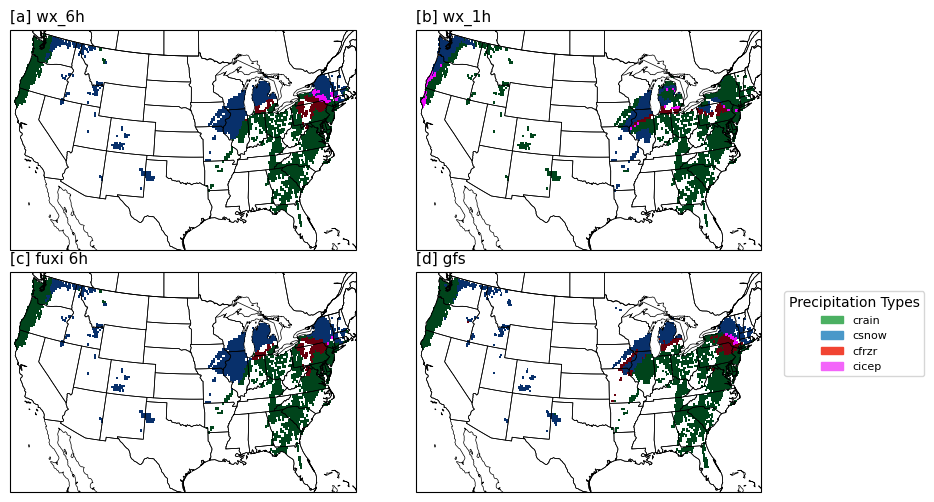

In [10]:
extent = [-120, -75, 26, 50]
fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(10, 6),
                       gridspec_kw={'wspace': 0.1, 'hspace': 0.1},
                       subplot_kw={'projection': ccrs.LambertConformal()})
conus_plot(ax[0,0],wx_6h,extent, '[a] wx_6h')  
conus_plot(ax[0,1],wx_1h,extent, '[b] wx_1h') 
conus_plot(ax[1,0],fuxi_6h,extent, '[c] fuxi 6h') 
conus_plot(ax[1,1],gfs,extent, '[d] gfs', show_legend = True, if_gfs= True) 
# fig.savefig('ptype.pdf', bbox_inches='tight')#, dpi=300

In [11]:
path_w6 ='/glade/u/home/sakor/work/CREDIT/wx_former_6h/2020-12-24T00Z/pred_2020-12-24T00Z_036.nc'
path_w1 = '/glade/u/home/sakor/work/CREDIT/wx_former_1h/2020-12-24T00Z/pred_2020-12-24T00Z_036.nc'
path_f6 = '/glade/u/home/sakor/work/CREDIT/fuxi_6h/2020-12-24T00Z/pred_2020-12-24T00Z_036.nc'
gfs = '/glade/work/sakor/gfs/gfs.0p25.2020122518.f000.grib2'

In [12]:
wx_6h = mask_cptye_with_gfs(path_w6,gfs)
wx_1h =mask_cptye_with_gfs(path_w1,gfs)
fuxi_6h =  mask_cptye_with_gfs(path_f6,gfs)

In [13]:
gfs = xr.open_dataset(
        gfs,
        engine='cfgrib',
        backend_kwargs={'filter_by_keys': {'stepType': 'instant', 'typeOfLevel': 'surface'}},
        decode_timedelta=False, 
    )

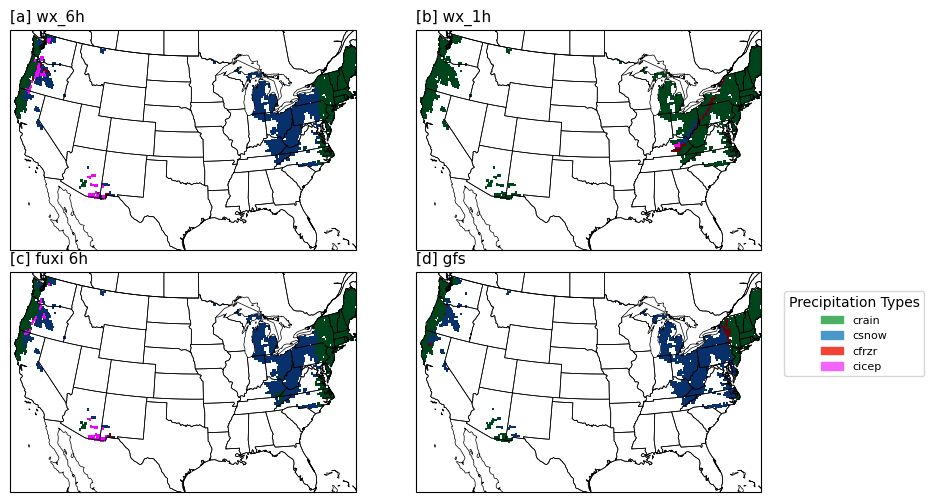

In [14]:
extent = [-120, -75, 26, 50]
fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(10, 6),
                       gridspec_kw={'wspace': 0.1, 'hspace': 0.1},
                       subplot_kw={'projection': ccrs.LambertConformal()})
conus_plot(ax[0,0],wx_6h,extent, '[a] wx_6h')  
conus_plot(ax[0,1],wx_1h,extent, '[b] wx_1h') 
conus_plot(ax[1,0],fuxi_6h,extent, '[c] fuxi 6h') 
conus_plot(ax[1,1],gfs,extent, '[d] gfs', show_legend = True, if_gfs= True) 
# fig.savefig('ptype.pdf', bbox_inches='tight')#, dpi=300

In [85]:
%%bash
pwd

/glade/work/sakor/miles-credit/applications


# North American Winter Storm Feb 13 - 17, 2021

In [76]:
path1 = '/glade/u/home/sakor/work/CREDIT/wx_former_6h/2021-02-13T00Z/pred_2021-02-13T00Z_012.nc'
path2 = '/glade/u/home/sakor/work/CREDIT/fuxi_6h/2021-02-13T00Z/pred_2021-02-13T00Z_012.nc'
path3 = '/glade/u/home/sakor/work/CREDIT/wx_former_1h/2021-02-13T00Z/pred_2021-02-13T00Z_012.nc'
path_g = '/glade/work/sakor/gfs/gfs.0p25.2021021312.f000.grib2'

In [77]:
gfs = xr.open_dataset(
        path_g,
        engine='cfgrib',
        backend_kwargs={'filter_by_keys': {'stepType': 'instant', 'typeOfLevel': 'surface'}},
        decode_timedelta=False, 
    )

In [78]:
wx_6h = mask_cptye_with_gfs(path1,path_g)
fx_6h = mask_cptye_with_gfs(path2,path_g)
wx_1h = mask_cptye_with_gfs(path3,path_g)

/glade/derecho/scratch/sakor/tmp/ipykernel_27093/2349126577.py:14: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


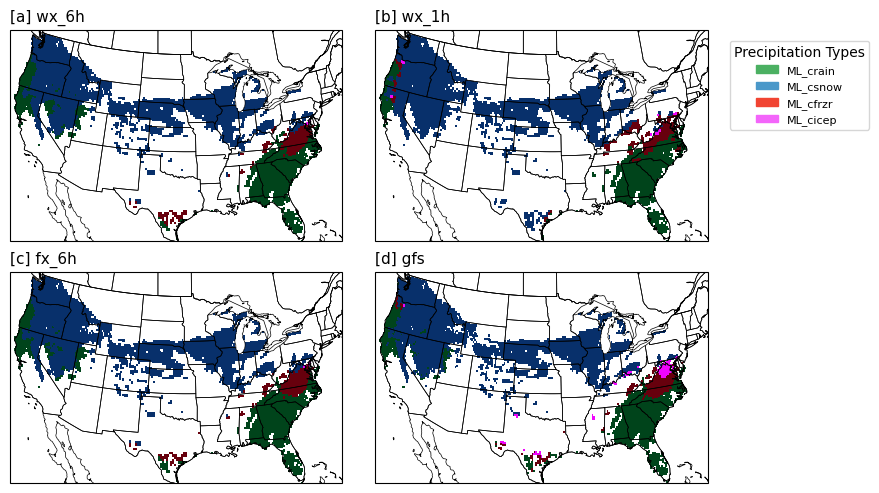

In [79]:
extent = [-120, -75, 26, 50]
fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(9, 6),
                       gridspec_kw={'wspace': 0.1, 'hspace': 0.1},
                       subplot_kw={'projection': ccrs.LambertConformal()})
conus_plot(ax[0,0],wx_6h,extent, '[a] wx_6h')
conus_plot(ax[0,1],wx_1h,extent, '[b] wx_1h',show_legend = True) 
conus_plot(ax[1,0],fx_6h,extent, '[c] fx_6h')
conus_plot(ax[1,1],gfs,extent, '[d] gfs',if_gfs= True) 

# Add main figure title
# fig.suptitle('2021-02-13T00Z_006',y=0.95, fontsize=8, fontweight='bold')

# Adjust layout to prevent title overlap
plt.tight_layout()

In [80]:
path_2_mping_json='/glade/campaign/cisl/aiml/ai2es/winter_ptypes/mping_hourly/mping_raw2021-02-13_12:00:00.json'

In [81]:
with open(path_2_mping_json) as f:
    json_data = json.load(f)

In [82]:
 
# Custom purple colormap
def mping_class(ax,json_data,title,extent):
    custom_colors = ['#ffe6ff', 'magenta']  # Light pink to full magenta
    magenta_cmap = mcolors.LinearSegmentedColormap.from_list("magenta_custom", custom_colors)

    
    # Classification function
    def classify_precip(description):
        desc = description.lower()
        if "freezing drizzle" in desc or "freezing rain" in desc:
            return "Freezing Rain"
        elif "drizzle" in desc or "rain" in desc:
            return "Rain"
        elif "snow" in desc or "graupel" in desc:
            return "Snow"
        elif "sleet" in desc or "ice pellets" in desc:
            return "Ice Pellets"
        else:
            return "Other"
    
    # Grouping coordinates
    grouped_points = defaultdict(list)
    for obs in json_data:
        label = classify_precip(obs["description"])
        lon, lat = obs["geom"]["coordinates"]
        grouped_points[label].append((lon, lat))
    
    # Assign colormaps to classes
    colormap_dict = {
        "Rain": plt.colormaps["Greens"],
        "Snow": plt.colormaps["Blues"],
        "Freezing Rain": plt.colormaps["Reds"],
        "Ice Pellets": magenta_cmap    }
    
    # Plotting
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
    ax.add_feature(cfeature.STATES, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    
    # Plot each group with a distinct color from its colormap
    for i, (label, coords) in enumerate(grouped_points.items()):
        lons, lats = zip(*coords)
        cmap = colormap_dict.get(label, plt.cm.gray)
        color = cmap(0.7)  # pick mid-shade
        ax.scatter(
            lons, lats,
            color=color,
            label=label,
            s=40,
            transform=ccrs.PlateCarree(),
            edgecolor='k', linewidth=0.3,alpha = 1.0
        )
    ax.set_title(title, fontweight='regular', fontsize=11, loc='left')
    ax.legend(
        title="Precip Class",
        loc='center left',
        bbox_to_anchor=(-0.76, 0.5),  # X shifts it to the left
        fontsize='small',
        title_fontsize='small',
        frameon=False
    )
    # ax.legend(title="Precip Class", loc="lower left", fontsize="small")
    # plt.title("Precipitation Types with Custom Colormaps")
    plt.subplots_adjust(left=0.05, right=0.95, top=0.92, bottom=0.08)
    # plt.show()


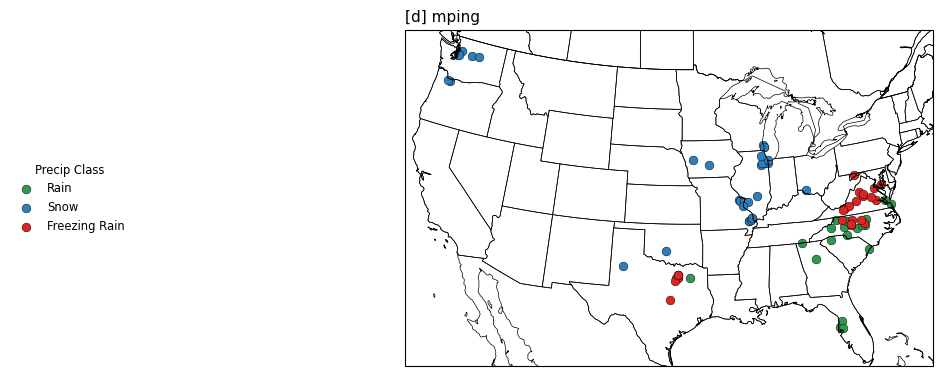

In [83]:
fig, ax = plt.subplots(
        figsize=(6, 4),
        subplot_kw={'projection': ccrs.LambertConformal()}
    )

mping_class(ax,json_data,'[d] mping', [-120, -75, 26, 50])

/glade/derecho/scratch/sakor/tmp/ipykernel_27093/3592553632.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


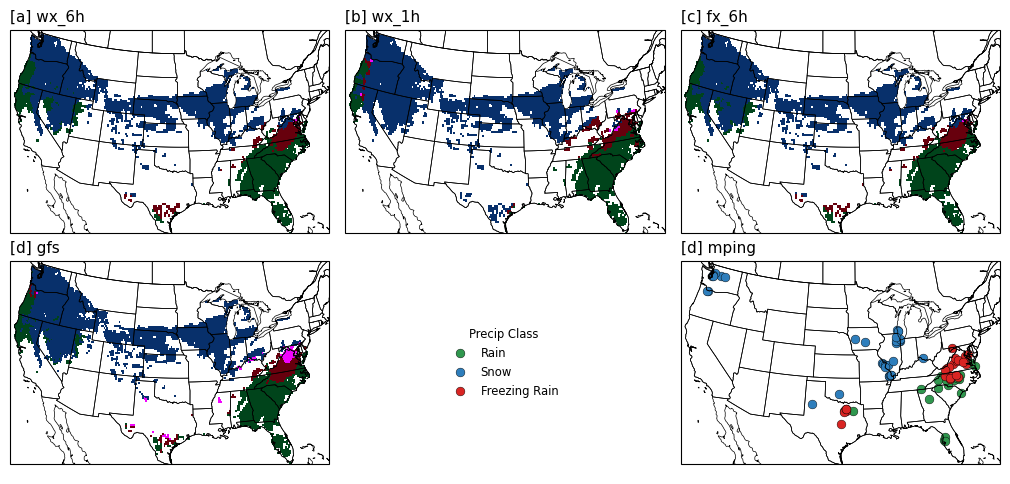

In [84]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(11, 5.5),
                       gridspec_kw={'wspace': 0.05, 'hspace': 0.0},
                       subplot_kw={'projection': ccrs.LambertConformal()})

conus_plot(ax[0,0], wx_6h, extent, '[a] wx_6h')
conus_plot(ax[0,1], wx_1h, extent, '[b] wx_1h') 
conus_plot(ax[0,2], fx_6h, extent, '[c] fx_6h')
conus_plot(ax[1,0], gfs, extent, '[d] gfs', if_gfs=True)
ax[1,1].axis("off")

mping_class(ax[1,2],json_data,'[d] mping', extent)

plt.tight_layout()
plt.show()
